In [11]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "-1"
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm.auto import tqdm
import torch
from torch import nn
import gin
import pickle
import io
from sparse_causal_model_learner_rl.trainable.gumbel_switch import WithInputSwitch, sample_from_logits_simple
from sparse_causal_model_learner_rl.visual.learner_visual import select_threshold, graph_for_matrices
gin.enter_interactive_mode()

In [2]:
ckpt = '/home/sergei/ray_results/ve5_rec_nonlin_gnn_gumbel_siamese_l2_ve5_dec_rec/main_fcn_489d0_00000_0_2021-01-27_13-36-31/checkpoint_4000/checkpoint'

In [3]:
class LinearModel(nn.Module):
    def __init__(self, input_shape):
        super(LinearModel, self).__init__()
        self.layer = nn.Linear(in_features=10, out_features=1, bias=True)
    def forward(self, x):
        return self.layer(x)

In [5]:
import ray
ray.init(address='10.90.38.7:6379', ignore_reinit_error=True)

2021-01-27 16:00:44,717	INFO worker.py:651 -- Connecting to existing Ray cluster at address: 10.90.38.7:6379


{'node_ip_address': '10.90.38.7',
 'raylet_ip_address': '10.90.38.7',
 'redis_address': '10.90.38.7:6379',
 'object_store_address': '/tmp/ray/session_2021-01-27_13-36-29_018819_1732/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2021-01-27_13-36-29_018819_1732/sockets/raylet',
 'webui_url': '127.0.0.1:8265',
 'session_dir': '/tmp/ray/session_2021-01-27_13-36-29_018819_1732',
 'metrics_export_port': 62152,
 'node_id': '306f320635e0fd1fbb8eaab941a51cc3d3c5f6cb'}

In [6]:
# https://github.com/pytorch/pytorch/issues/16797
class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else: return super().find_class(module, name)

In [7]:
with open(ckpt, 'rb') as f:
    learner = CPU_Unpickler(f).load()#pickle.load(f)

2021-01-27 16:00:53,591	WARNING session.py:20 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Selecting name 73ade6c2-60b0-11eb-b7e6-90e2baa1a248
Make environment VectorIncrement-v0 None {}


In [10]:
Ma = learner.model.Ma
Mf = learner.model.Mf

In [18]:
t_a = select_threshold(Ma, do_plot=False, do_log=False)
t_f = select_threshold(Mf, do_plot=False, do_log=False)

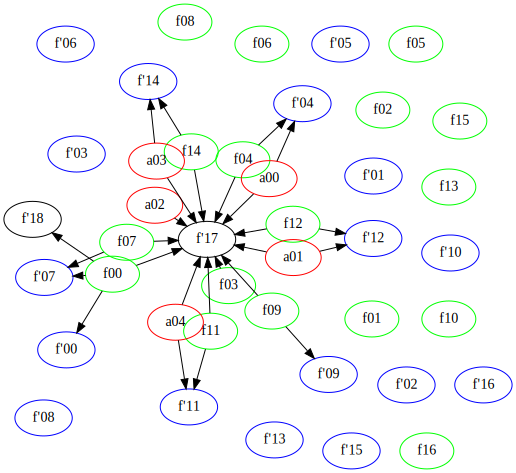

In [19]:
graph_for_matrices(learner.model, threshold_act=t_a, threshold_f=t_f, do_write=False)[0]

In [59]:
from collections import OrderedDict

import gin
import matplotlib.cm as cm
import numpy as np
import pandas as pd
import plotly.graph_objs as go
import seaborn as sns
import torch
from graphviz import Digraph
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import traceback
from causal_util.helpers import lstdct2dctlst
from sparse_causal_model_learner_rl.trainable.helpers import params_shape, flatten_params
from sparse_causal_model_learner_rl.trainable.helpers import unflatten_params
import logging
import os
from imageio import imread
import cv2
import networkx

ModuleNotFoundError: No module named 'networkx'

In [90]:
def graph_for_matrices(model, threshold_act=0.2, threshold_f=0.2, do_write=True,
                       additional_features=None,
                       engine='dot'):
    """Visualize matrices as a graph."""
    
    if additional_features is None:
        additional_features = []
    
    Mf, Ma = model.Mf, model.Ma
    # dimension
    actions = Ma.shape[1]
    features = Mf.shape[1]
    
    Mf_t = np.abs(Mf) > threshold_f
    Ma_t = np.abs(Ma) > threshold_act
    
    keep_actions = np.where(np.max(Ma_t, axis=0))[0]
    keep_features = np.where(Mf_t)
    keep_features = set(keep_features[0]) | set(keep_features[1])

    ps = Digraph(name='Causal model', engine=engine)  # ,
    # node_attr={'shape': 'plaintext'})

    additional_features_dct = dict(zip(range(Mf.shape[0])[-len(additional_features):], additional_features))
    
    def feature_name(idx):
        if idx in additional_features_dct:
            return additional_features_dct[idx]
        else:
            return 'f%02d' % idx
    
    # adding features nodes
    for f in range(features):
        if f not in keep_features: continue
        ps.node(feature_name(f), color='green')
#         ps.node("f'%02d" % f, color='blue')

    # adding action edges
    for a in range(actions):
        if a not in keep_actions: continue
        ps.node('a%02d' % a, color='red')

    # adding edges
    edges = 0

    for f1, a in zip(*np.where(Ma_t)):
        ps.edge('a%02d' % a, feature_name(f1))
        edges += 1

    for f1, f in zip(*np.where(Mf_t)):
        ps.edge(feature_name(f), feature_name(f1))
        edges += 1

    max_edges = features ** 2 + actions * features
    percent = int(100 - 100. * edges / max_edges)
    # print("Number of edges: %d out of %d, sparsity %.2f%%" % \
    #       (edges, max_edges, percent))

    f_out = None
    if do_write:
        f_out = f"CausalModel"
        ps.render(filename=f_out, format='png')

    return ps, f_out

In [91]:
g = graph_for_matrices(learner.model, threshold_act=t_a, threshold_f=t_f, do_write=False, additional_features=None)[0]

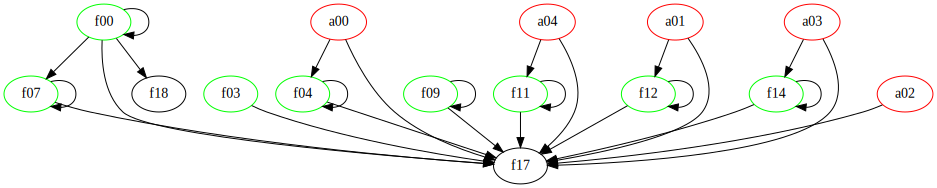

In [92]:
g

In [ ]:
#fdp good, dot good